In [1]:
%matplotlib inline

In [9]:
import mne
import pathlib
import numpy as np
from matplotlib import pyplot as plt, ticker
from scipy import stats
from matplotlib import pyplot as plt, ticker, patheffects, colors

#plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

'matplotlib'

In [13]:
RAW_DATA_PATH = pathlib.Path("/work/PeterHoueWisnewski#4605/CogNeuro24/EEG/Exam/EEG")

SESSIONS = [
    "group13_a2"
]

---

In [14]:
epochs_per_participant = [mne.read_epochs(RAW_DATA_PATH.joinpath(SESSION + "-epo.fif")) for SESSION in SESSIONS]
all_epochs = mne.concatenate_epochs(epochs_per_participant)

Reading /work/PeterHoueWisnewski#4605/CogNeuro24/EEG/Exam/EEG/group13_a2-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
10988 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_47344/3415278017.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epochs_per_participant)


Not setting metadata
10988 matching events found
Applying baseline correction (mode: mean)


# Comparing evoked GFPs

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


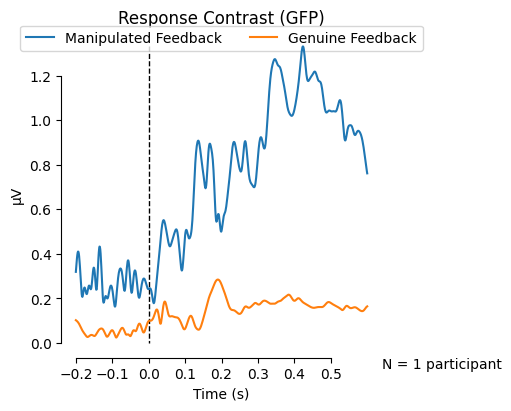

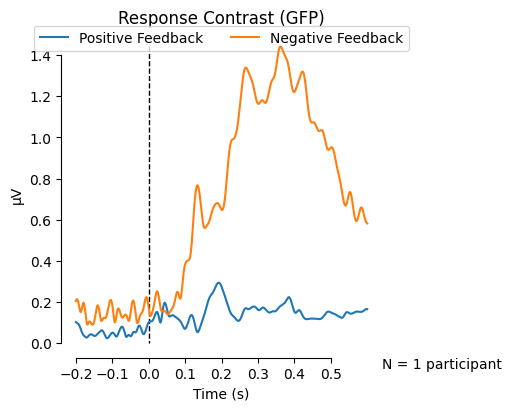

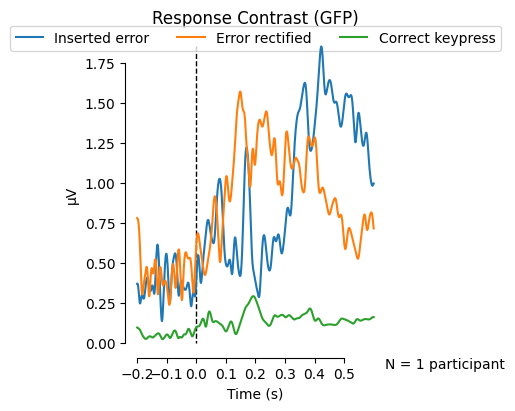

In [5]:
def compare_evoked_activity(conditions, participant_selection = "all"):
    included_epochs = all_epochs
    amount_participants_included = len(epochs_per_participant)

    fig = mne.viz.plot_compare_evokeds(
        evokeds={condition: included_epochs[event_keys].average() for condition, event_keys in conditions.items()},
        ci = 0.95,
        combine = "gfp",
        title = "Response Contrast",
        show = False
    )[0]
    fig.set_size_inches((5, 4))
    ax = fig.axes[0]
    ax.autoscale()
    ax.get_legend().remove()
    ax.legend(
        ncol = len(conditions),
        labels = conditions.keys(), 
        bbox_to_anchor = (0.5, 1.04), 
        loc = "upper center"
    )
    ax.annotate(
        f"""N = {amount_participants_included} participant{"s" if amount_participants_included > 1 else ""}""",
        xy = (1, 0),
        xycoords = "axes fraction",
        va = "top"
    )

compare_evoked_activity(
    conditions = {
        "Manipulated Feedback": ("error inserted", "error rectified"),
        "Genuine Feedback": ("correct", "incorrect"),
    },
    participant_selection=[1]
)

compare_evoked_activity(
    conditions = {
        "Positive Feedback": ("correct", "error rectified"),
        "Negative Feedback": ("error inserted", "incorrect"),
    },
    participant_selection=[1]
)


compare_evoked_activity(
    conditions = {
        "Inserted error": ["error inserted"],
        "Error rectified": ["error rectified"],
        "Correct keypress": ["correct"],
    }
)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 30


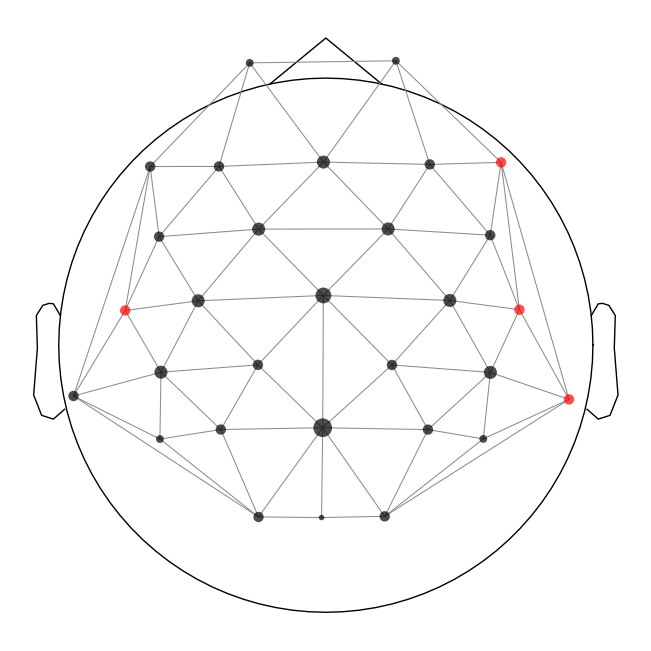

In [6]:
adjacency, ch_names = mne.channels.find_ch_adjacency(all_epochs.info, ch_type="eeg")
mne.viz.plot_ch_adjacency(all_epochs.info, adjacency, ch_names);

# Cluster-based permutation analysis

Using a threshold of 3.843153


/tmp/ipykernel_612/3598601523.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=211.965987
Running initial clustering …
Found 15 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

Using a threshold of 3.843153


/tmp/ipykernel_612/3598601523.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=52.022800
Running initial clustering …
Found 24 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

Using a threshold of 3.861363
stat_fun(H1): min=0.000000 max=18.448376
Running initial clustering …


/tmp/ipykernel_612/3598601523.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


Found 39 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

Using a threshold of 3.932438
stat_fun(H1): min=0.000000 max=15.564216
Running initial clustering …


/tmp/ipykernel_612/3598601523.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


Found 49 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

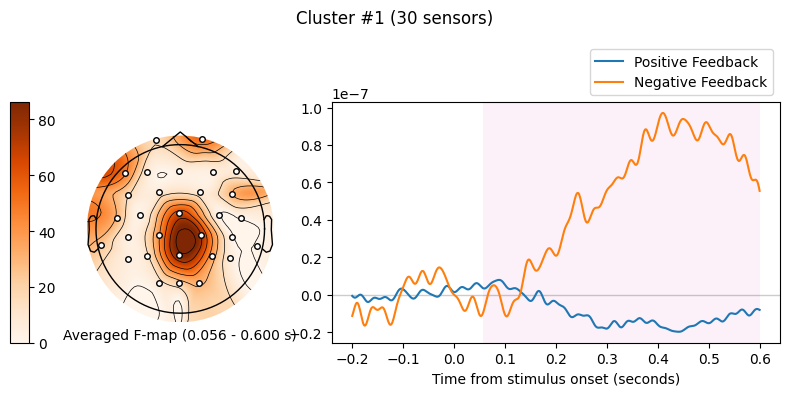

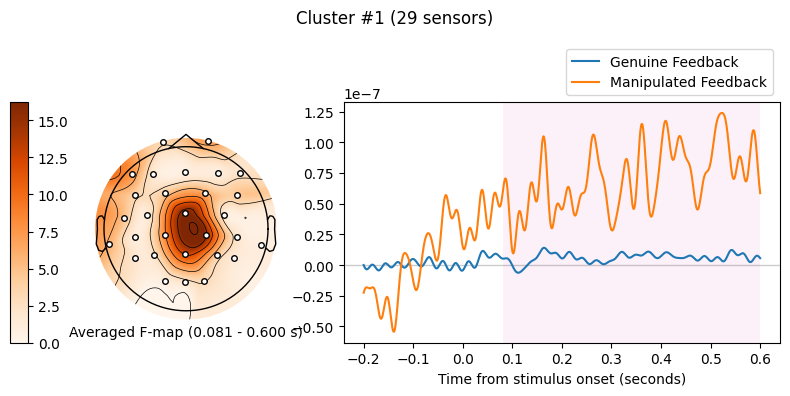

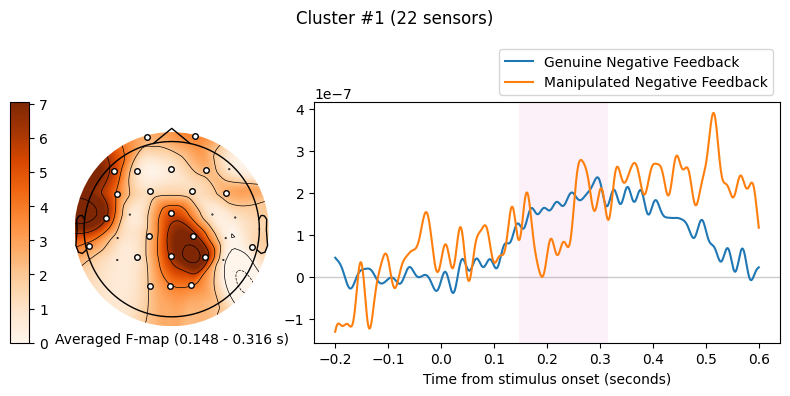

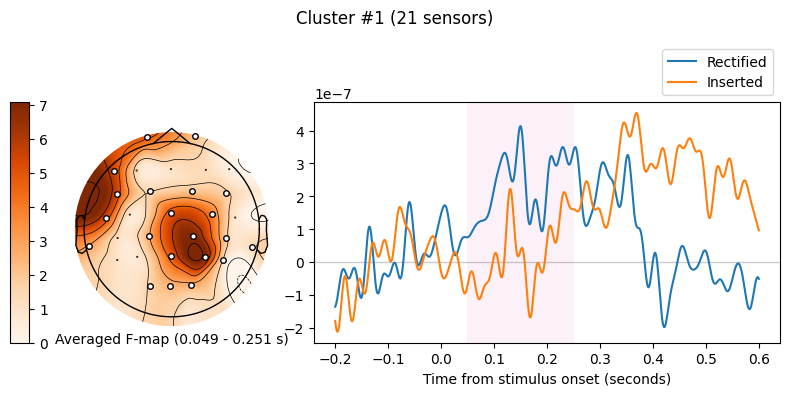

In [ ]:
def perform_cluster_permutation(conditions, p_threshold = 0.05):
    def transpose_data(epochs): 
        return np.transpose(epochs.get_data(copy = True), (0, 2, 1))

    transposed_data = [transpose_data(all_epochs[condition]) for condition in conditions.values()]

    F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(
        X = transposed_data,
        n_permutations=500, 
        adjacency=adjacency, 
        seed=69,
        n_jobs=-1, 
    )

    selected_clusters = [cluster for cluster, p_val in zip(clusters, p_values) if p_val < p_threshold]
    if not len(selected_clusters):
        print("No clusters reached set significance threshold of", p_threshold)
    else:
        for cluster_id, cluster in enumerate(selected_clusters):
            time_inds, space_inds = np.squeeze(cluster)
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)

            f_map = F_obs[time_inds, ...].mean(axis=0) # topography for stats
            sig_times = all_epochs.times[time_inds] # signals at the sensors contributing to the cluster

            mask = np.zeros((f_map.shape[0], 1), dtype=bool) # creating spatial mask
            mask[ch_inds, :] = True

            fig, (ax_colorbar, ax_topography, ax_signals) = plt.subplots(
                ncols = 3, 
                figsize=(8, 4), 
                width_ratios = [0.1, 1, 2.4], 
            )
            fig.suptitle(f"Cluster #{cluster_id + 1} ({len(ch_inds)} sensors)")

            image = mne.viz.plot_topomap(
                f_map,
                all_epochs.info,
                axes=ax_topography,
                cmap="Oranges",
                show=False,
                mask=mask
            )
            fig.colorbar(image[0], fraction = 0.6, cax = ax_colorbar)
            ax_topography.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

            ax_signals.axhline(
                y = 0, 
                color = "black",
                linewidth = 1,
                alpha = 0.2
            )
            for condition, cluster_signal in zip(conditions.keys(), transposed_data):
                ax_signals.plot(
                    all_epochs.times, 
                    cluster_signal[:, :, ch_inds].mean(axis=(0, 2)),
                    label=condition
                )
            ax_signals.legend(loc = "lower right", bbox_to_anchor = (1, 1))
            ax_signals.set_xlabel("Time from stimulus onset (seconds)")
            
            ax_signals.axvspan(
                sig_times[0], 
                sig_times[-1], 
                facecolor="C6", 
                alpha=0.1
            )

        plt.tight_layout()

perform_cluster_permutation(
    conditions = {
        "Positive Feedback": ("correct", "error rectified"),
        "Negative Feedback": ("incorrect", "error inserted")
    },
    p_threshold = 0.05
)
perform_cluster_permutation(
    conditions = {
        "Genuine Feedback": ("correct", "incorrect"),
        "Manipulated Feedback": ("error inserted", "error rectified")
    },
    p_threshold = 0.05
)
perform_cluster_permutation(
    conditions = {
        "Genuine Negative Feedback": ("incorrect"),
        "Manipulated Negative Feedback": ("error inserted")
    },
    p_threshold = 0.05
)

perform_cluster_permutation(
    conditions = {
        "Rectified": ("error rectified"),
        "Inserted": ("error inserted")
    },
    p_threshold = 0.05
)

# Image Map and Average Signal

Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


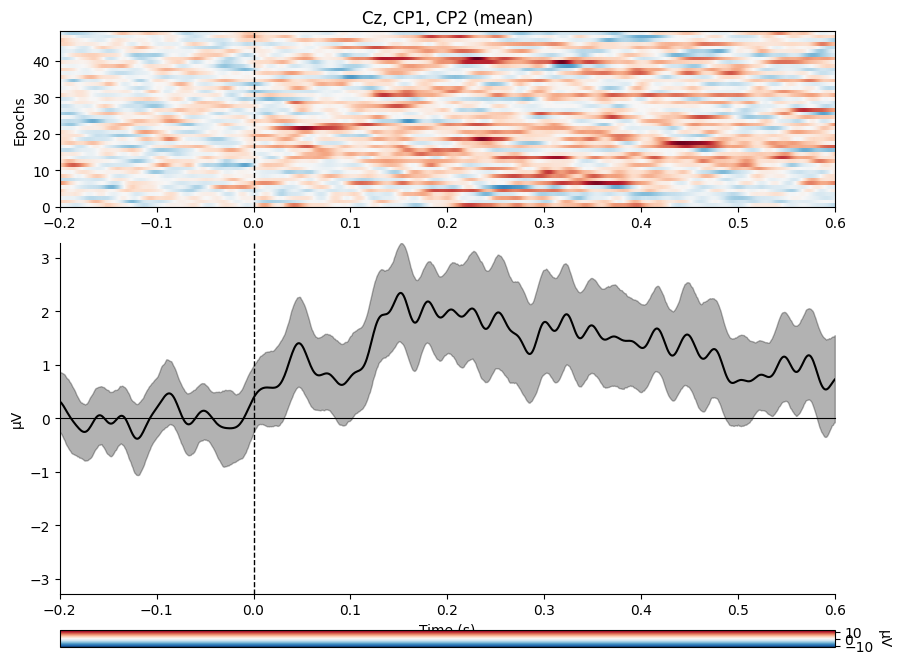

Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


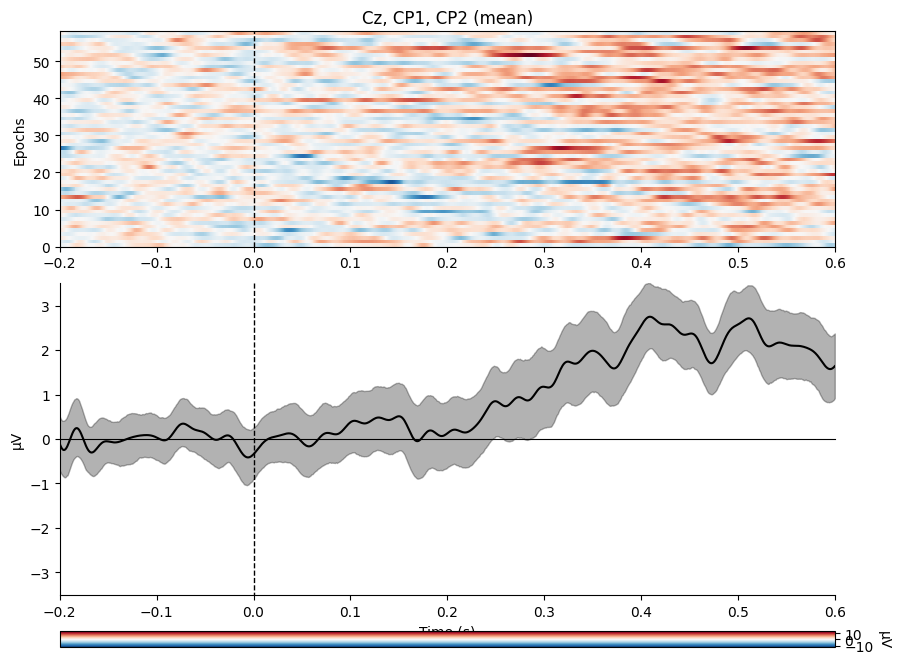

In [27]:
fig, axes = plt.subplots(figsize = (10, 8), nrows = 3, height_ratios=(0.3, .6, 0.03))
all_epochs[["error rectified"]].plot_image(picks = ["Cz","CP1","CP2"], combine="mean", axes = axes);
fig, axes = plt.subplots(figsize = (10, 8), nrows = 3, height_ratios=(0.4, .58, 0.03))
all_epochs[["error inserted"]].plot_image(picks = ["Cz","CP1","CP2"], combine="mean", axes= axes);



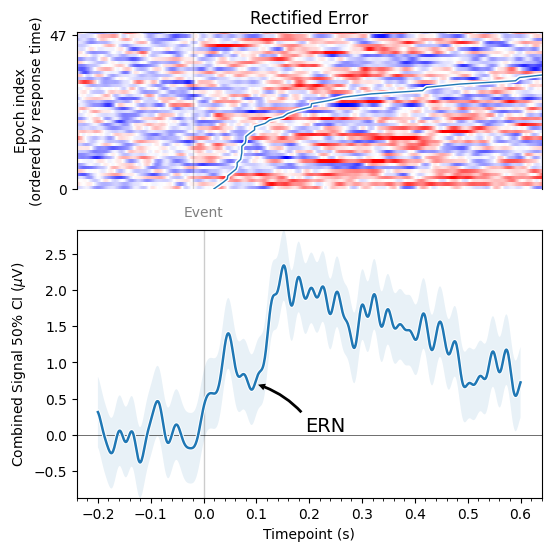

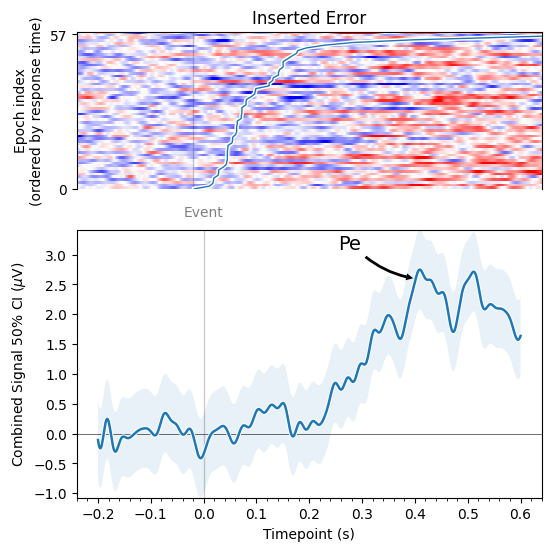

In [28]:
def sanity_check(evokeds, channels = None, title = None, annotation = None, ci = 0.5, scale = 25):
    evokeds = evokeds.copy().pick(channels)
    data = evokeds._get_data().mean(axis = 1) * 1e6

    fig, axes = plt.subplots(
        figsize = (5.4, 5.4), 
        nrows = 2, 
        height_ratios = [0.37, 0.63],
        layout="constrained",
        gridspec_kw = dict(hspace=0),
    )
    ax_epochs, ax_signal = axes

    if title:
        ax_epochs.set_title(title)

    for ax in axes:
        ax.axvline(
            x = 0, 
            color = "black",
            linewidth = 1,
            alpha = 0.2,
        )
    ax_signal.axhline(
        y = 0, 
        color = "black",
        linewidth = 0.5,
        alpha = 0.8,
    )
    ax_signal.annotate(
        "Event",
        xy = (0, 1.05),
        xycoords = ("data", "axes fraction"),
        ha = "center",
        alpha = 0.5,
    )

    signal_mean = data.mean(axis = 0)
    ax_signal.plot(
        evokeds.times,
        signal_mean,
        linewidth = 1.8,
        path_effects = [patheffects.Stroke(linewidth = 3.2, foreground = "white"), patheffects.Normal()],
    )
    ax_signal.fill_between(
        all_epochs.times, 
        *stats.norm.interval(ci, loc=signal_mean, scale = signal_mean.std()),
        alpha=0.1,
        edgecolor = "none"
    )

    ax_epochs.set_xticks([])
    ax_epochs.set_yticks([0, len(evokeds) - 1])
    ax_epochs.spines["bottom"].set_visible(False)
    ax_signal.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax_signal.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
    ax_signal.set_xlabel("Timepoint (s)")
    ax_signal.set_ylabel(("Combined " if channels and len(channels) > 1 else "") + f"Signal {ci:.0%} CI ($\\mu$V)")
    ax_signal.margins(y = 0)

    if annotation:
        ax_signal.annotate(
            annotation["caption"],
            xy=annotation["point"], 
            xycoords="data",
            xytext=annotation["offset"],
            textcoords="offset points",
            arrowprops=dict(
                width = 2,
                headwidth = 5,
                headlength = 5,
                facecolor = "black", 
                edgecolor = "none",
                shrink = 0.03,
                connectionstyle=f"""arc3,rad={annotation["arc"]}""",
            ),
            fontsize = 14,
            ha = "left",
            va = "center",
        )

    all_events = all_epochs.events
    intervals = []
    for evoked_timepoint, _, _ in evokeds.events:
        following_events = all_events[all_events[:, 0] > evoked_timepoint]
        following_keypresses = following_events[following_events[:, 2] == 1]
        timepoint_of_next_keypress = following_keypresses[0][0]
        intervals.append((timepoint_of_next_keypress - evoked_timepoint) / 1e3)

    data = data[np.argsort(intervals),:]
    ax_epochs.imshow(
        (data - data.mean()) / data.std(),
        origin = "lower",
        interpolation = "nearest",
        aspect = "auto",
        cmap = "bwr",
        vmin = -3,
        vmax = 3,
        extent = [evokeds.times[0], evokeds.times[-1], 0, len(intervals)]
    )
    ax_epochs.plot(
        np.sort(intervals),
        np.arange(len(intervals)),
        linewidth = 1,
        color = "C0",
        path_effects = [patheffects.Stroke(linewidth = 3.2, foreground = "white"), patheffects.Normal()],
    )
    ax_epochs.set_xlim(evokeds.times[0], evokeds.times[-1])
    ax_epochs.set_ylabel("Epoch index\n(ordered by response time)")

    #ax_topo = ax_signal.inset_axes([0.84, 0.9, 0.2, 0.2], in_layout = False)
    #mne.viz.plot_sensors(
    #    evokeds.info,
    #    axes = ax_topo,
    #    pointsize = 1,
    #    sphere=(0, 0.02, 0, 0.1),
    #)
    #ax_topo.axis("off")

    plt.show()

#sanity_check(
#    evokeds= all_epochs[["incorrect", "error inserted"]], 
#    title = "Negative Visual Feedback",
#    channels = ["O1", "Oz", "O2", "P7", "P8"],
#    annotation = dict(caption = "N170", point = (0.2, 0.67), offset = (40, -20), arc = 0.15)
#)

sanity_check(
    evokeds= all_epochs[["error rectified"]], 
    title = "Rectified Error",
    channels = ["Cz", "CP1", "CP2"],
    annotation = dict(caption = "ERN", point = (0.10, 0.70), offset = (35, -30), arc = 0.15)
)

sanity_check(
    evokeds= all_epochs[["error inserted"]], 
    title = "Inserted Error",
    channels = ["Cz", "CP1", "CP2"],
    annotation = dict(caption = "Pe", point = (0.4, 2.6), offset = (-55, 25), arc = 0.15)
)


# Windowed Mean 

In [30]:
from pathlib import Path
all_epochs.pick(["eeg"])

Number of events,10988
Events,keypress: 5494trial/correct: 4975trial/error inserted: 58trial/error rectified: 48trial/incorrect: 413
Time range,-0.200 – 0.600 s
Baseline,-0.200 – 0.000 s


In [31]:
# extract the trials
epochs_inserted = all_epochs["error inserted"] # all the inserted trials
epochs_rectified = all_epochs["error rectified"] # all the rectified trials

picks = ["Cz", "CP1", "CP2"]

tmin = 0
tmax = 0.150

# extracting the data
data_inserted = epochs_inserted.get_data(picks = picks, tmin = tmin, tmax = tmax)
data_rectified = epochs_rectified.get_data(picks = picks, tmin = tmin, tmax = tmax)

data_inserted_mean = np.mean(data_inserted, axis=2) # averaging over the third dimension of the data (time)
print(data_inserted_mean.shape)

data_inserted_mean = np.mean(data_inserted_mean, axis=1) # averaging over the second dimension of the data (channels)
print(data_inserted_mean.shape)

# you can also do this in one line
data_rectified_mean = np.mean(data_rectified, axis=(1,2)) # averaging over the second and third dimension of the data (channels and time)
print(data_rectified_mean.shape)

stats.ttest_ind(data_rectified_mean, data_inserted_mean)

(58, 3)
(58,)
(48,)


TtestResult(statistic=2.521803432542611, pvalue=0.013192012464768102, df=104.0)

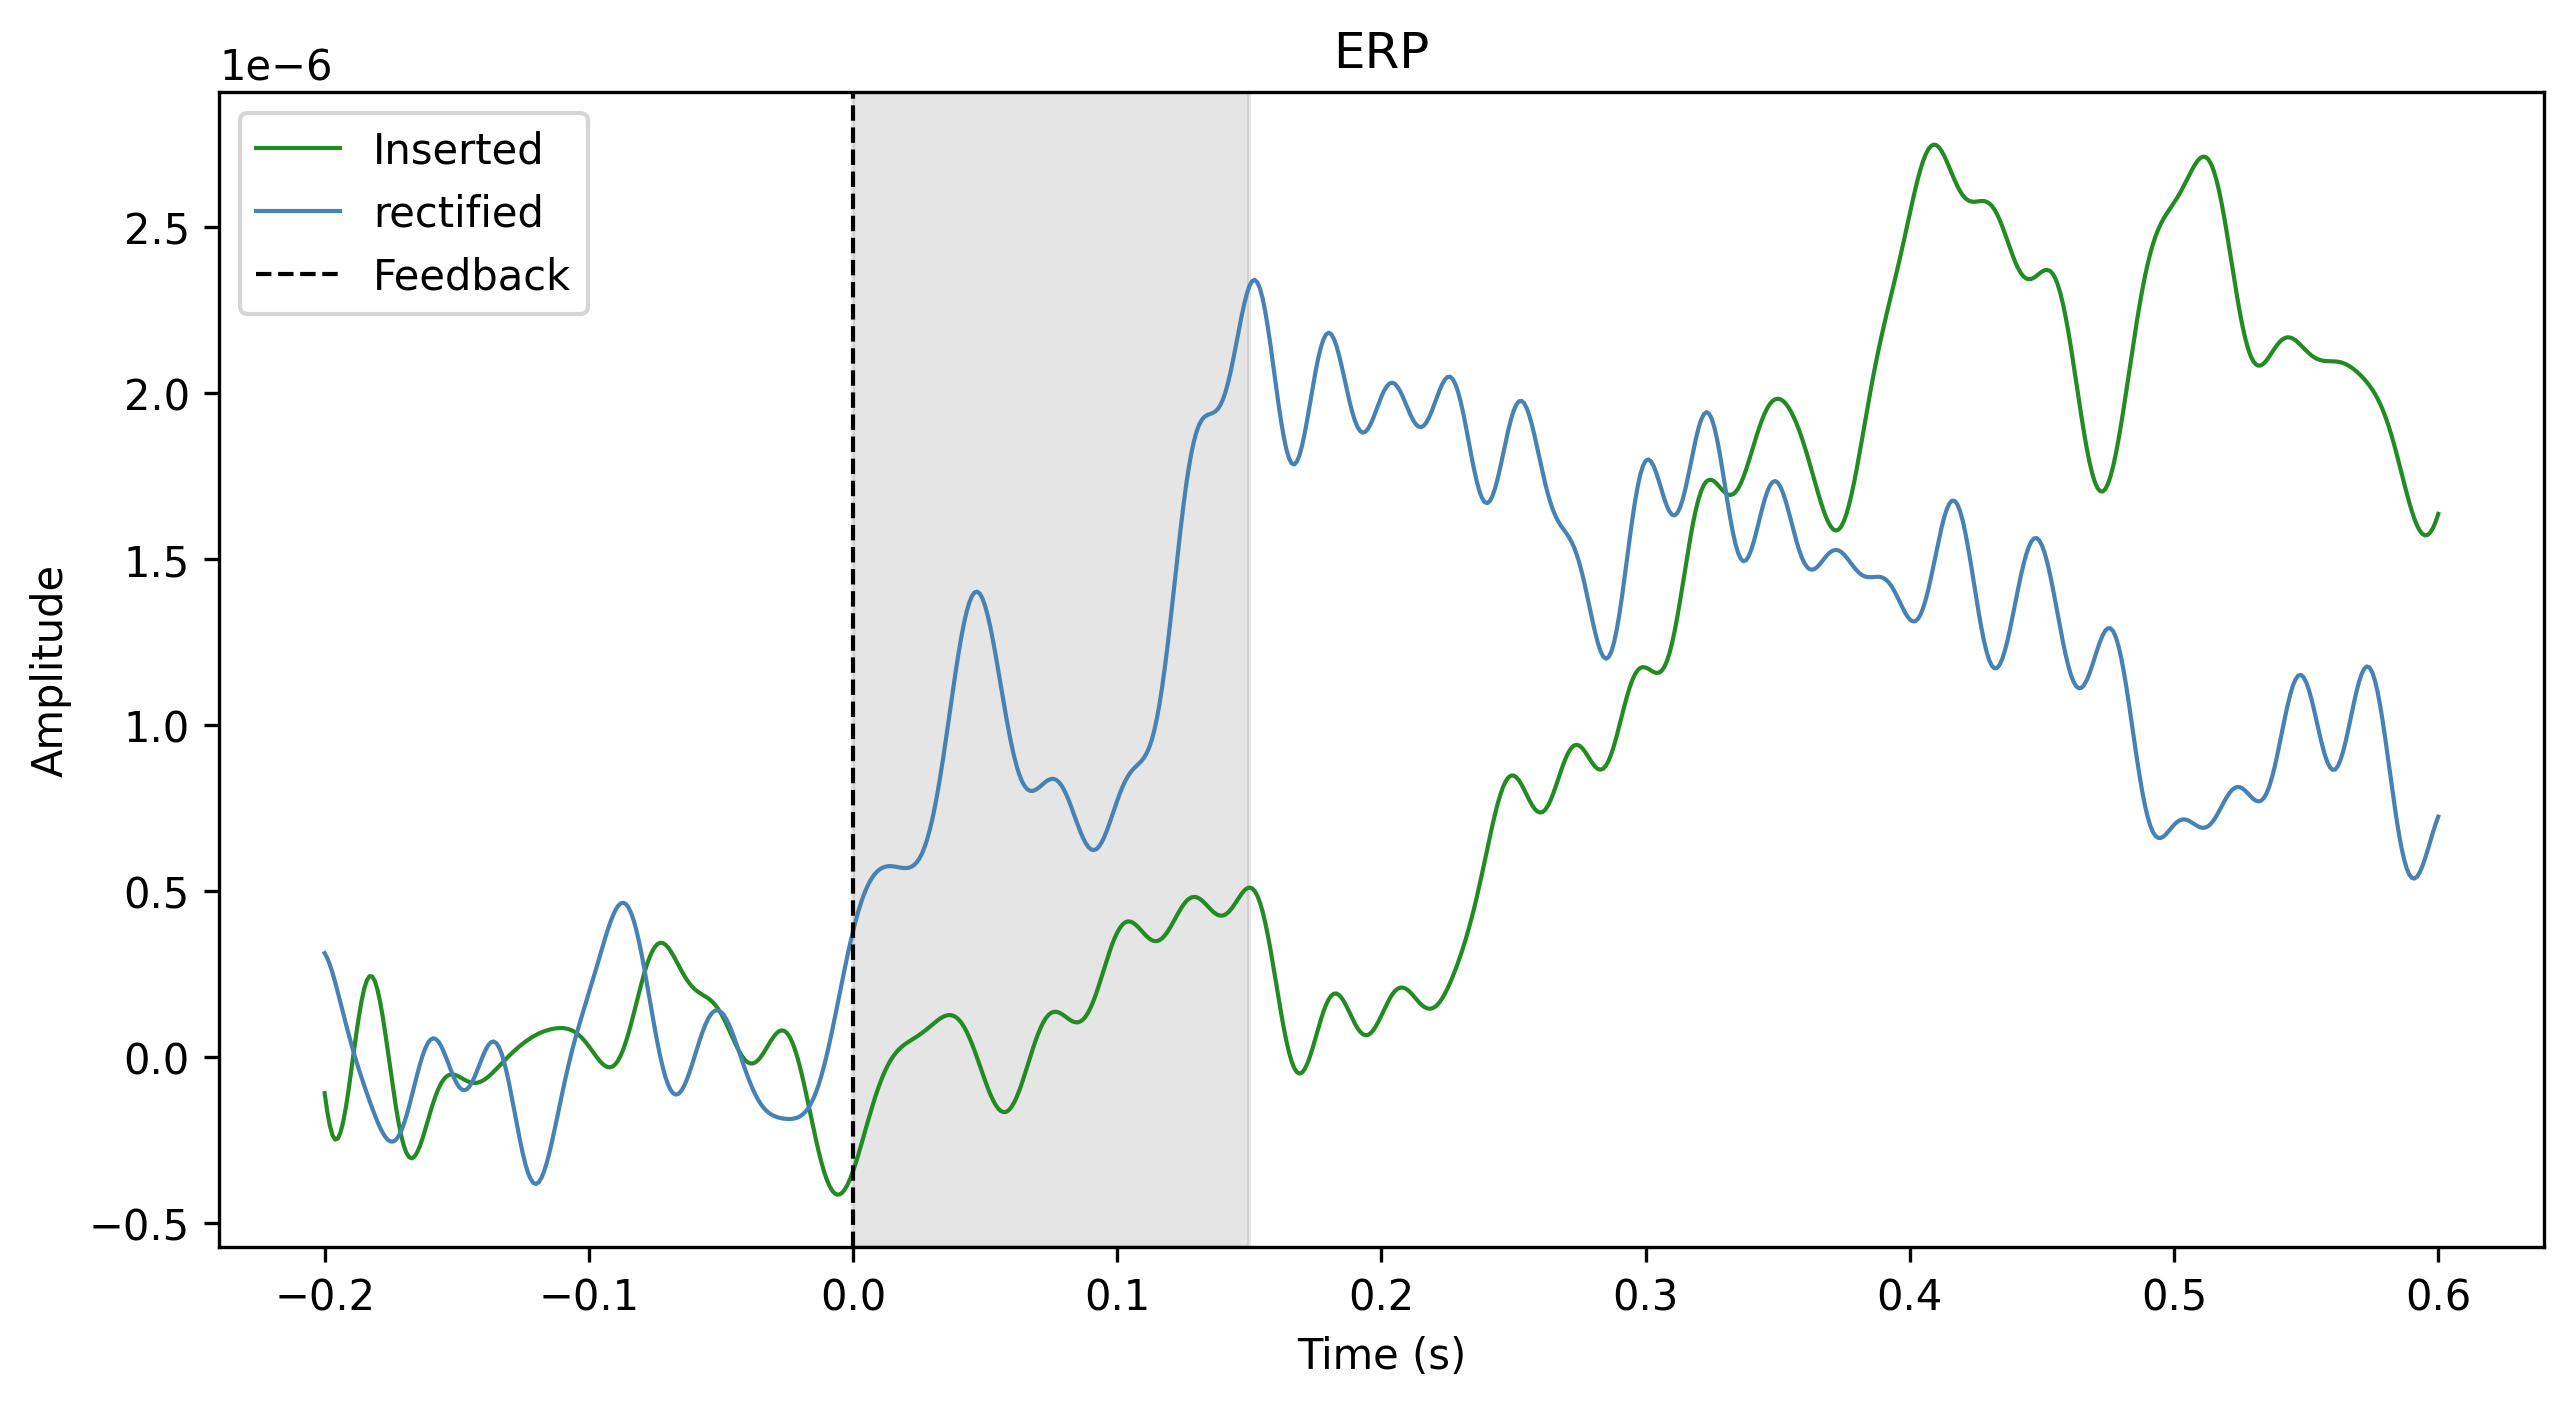

In [32]:

plot_data_incorrect = epochs_inserted.get_data(picks=picks, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data_correct = epochs_rectified.get_data(picks=picks, copy = True).mean(axis=(0, 1)) # mean over channels and trials 

times = epochs_inserted.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

# plot the time course
ax.plot(times, plot_data_incorrect.T, label="Inserted", linewidth=1, color="forestgreen")
ax.plot(times, plot_data_correct.T, label="rectified", linewidth=1, color="steelblue")

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", label = "Feedback", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP")
ax.legend(loc = "upper left")

In [33]:
# extract the trials
epochs_inserted = all_epochs["error inserted"] # all the inserted trials
epochs_rectified = all_epochs["error rectified"] # all the rectified trials

picks = ["Cz", "CP1", "CP2"]

tmin = 0.350
tmax = 0.550

# extracting the data
data_inserted = epochs_inserted.get_data(picks = picks, tmin = tmin, tmax = tmax)
data_rectified = epochs_rectified.get_data(picks = picks, tmin = tmin, tmax = tmax)

data_inserted_mean = np.mean(data_inserted, axis=2) # averaging over the third dimension of the data (time)
print(data_inserted_mean.shape)

data_inserted_mean = np.mean(data_inserted_mean, axis=1) # averaging over the second dimension of the data (channels)
print(data_inserted_mean.shape)

# you can also do this in one line
data_rectified_mean = np.mean(data_rectified, axis=(1,2)) # averaging over the second and third dimension of the data (channels and time)
print(data_rectified_mean.shape)

stats.ttest_ind(data_rectified_mean, data_inserted_mean)

(58, 3)
(58,)
(48,)


TtestResult(statistic=-2.623290155550491, pvalue=0.010017651189893636, df=104.0)

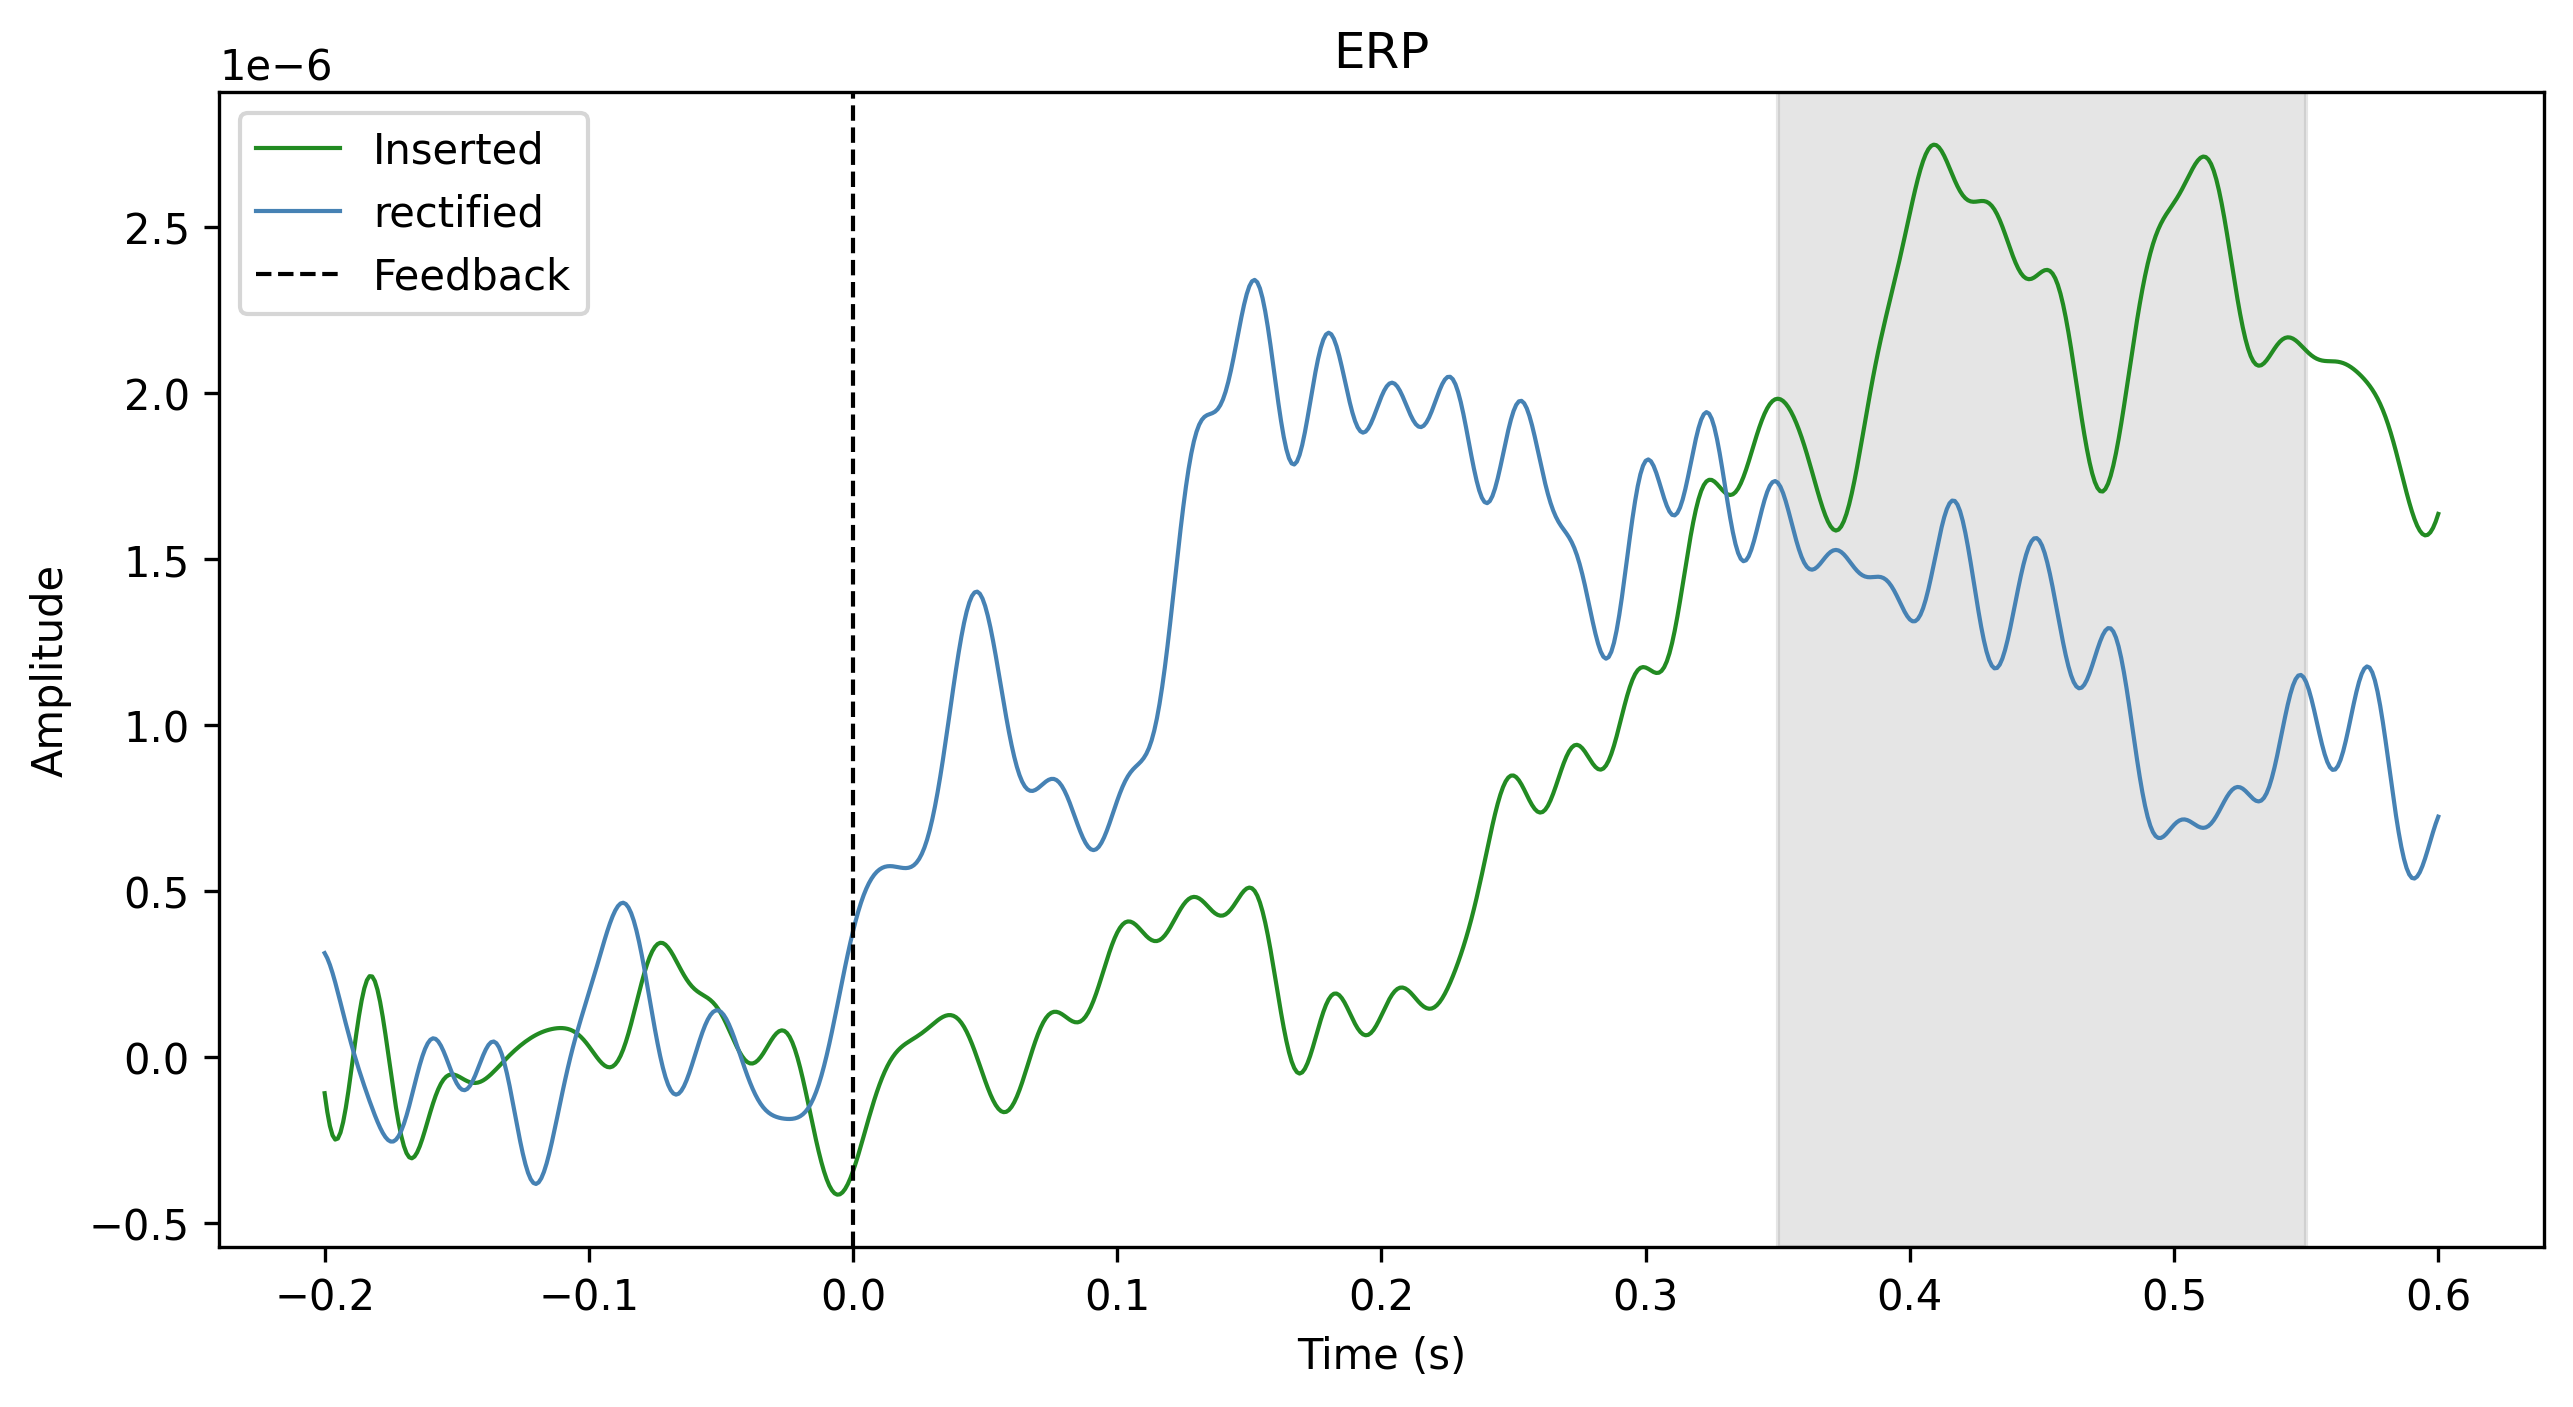

In [34]:

plot_data_incorrect = epochs_inserted.get_data(picks=picks, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data_correct = epochs_rectified.get_data(picks=picks, copy = True).mean(axis=(0, 1)) # mean over channels and trials 

times = epochs_inserted.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

# plot the time course
ax.plot(times, plot_data_incorrect.T, label="Inserted", linewidth=1, color="forestgreen")
ax.plot(times, plot_data_correct.T, label="rectified", linewidth=1, color="steelblue")

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", label = "Feedback", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP")
ax.legend(loc = "upper left")